# Setting Grafting Points

This script explains how to set the initial condition of chain ends. For demonstration, we compute the end-to-end distance of homopolymer. 

1. To compute the end-to-end distance, non-uniform initial condition is set.
2. For numerical stability with non-uniform initial points, we employ the alternating-direction implicit (ADI) and Crank–Nicolson methods, which has the second-order accuracy in $s$.

### 1. Import modules and set environment variables

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import polymerfts

# OpenMP environment variables
os.environ["MKL_NUM_THREADS"] = "1"  # always 1
os.environ["OMP_STACKSIZE"] = "1G"
os.environ["OMP_MAX_ACTIVE_LEVELS"] = "1"  # 0, 1
os.environ["OMP_NUM_THREADS"] = "2"  # 1 ~ 4

# GPU environment variables
os.environ["LFTS_GPU_NUM_BLOCKS"]  = "256"
os.environ["LFTS_GPU_NUM_THREADS"] = "256"
os.environ["LFTS_NUM_GPUS"] = "1" # 1 ~ 2

### 2. Setup some simulation parameters

\begin{align}
N &= 100 \\
\Delta s &= 1/N = 0.01 \\
R_0 & = bN^{1/2} \\
L_x &= 6.0 R_0 \\
L_y &= 6.0 R_0 \\
L_z &= 6.0 R_0 \\
V &= L_x L_y L_z\\ 
m_x &= 32 \\
m_y &= 32 \\
m_z &= 32 \\
b_A/b &= 1.5 \\
\end{align}

In [22]:
# Simulation parameters
nx = [32,32,32]               # grid number
lx = [6.0,6.0,6.0]            # box size
ds = 0.01                     # contour step interval
stat_seg_lengths = {"A":1.3}   # statistical segment lengths

boundary_conditions = ["periodic", "periodic",  # boundary conditions (periodic, reflecting, absorbing)
                       "periodic", "periodic",
                       "periodic", "periodic"]

### 3. Create a factory

* The factory will create the following instances for chosen platform and data-type.
    * simulation_box
    * molecules
    * propagator_computation_optimizer
    * solver

In [23]:
# Select platform ("cuda" or "cpu-mkl") and data-type ("real" or "complex")
reduce_gpu_memory_usage = False
factory = polymerfts.PlatformSelector.create_factory("cpu-mkl", reduce_gpu_memory_usage, "real")
factory.display_info()

==================== MKL Version ====================
Major version:           2021
Minor version:           0
Update version:          4
Product status:          Product
Build:                   20210904
Platform:                Intel(R) 64 architecture
Processor optimization:  Intel(R) Architecture processors


In [24]:
# Create an instance for computation box
cb = factory.create_computation_box(nx, lx, bc=boundary_conditions) 
# Create an instance for molecule information with block segment information and chain model ("continuous" or "discrete")
molecules = factory.create_molecules_information("continuous", ds, stat_seg_lengths)

### 4. Add homopolymers

1. In the graph notation, there are two junctions, [0, 1], and there are one block, [[0, 1]].
2. One chain end (node 0) will be initilized with $q_{init}({\bf r};{\textrm G})$.

In [25]:
(v, u) = (0, 1)

# Grafting points
grafting_points = {v:"G"}  # node 0 will be initialized with q_init["G"]

# Add Homopolymers
volume_fraction = 1.0
blocks = [["A", 1.0, v, u]]   # monomer type, statistical segment length, start index, end index
molecules.add_polymer(volume_fraction, blocks, grafting_points)

### 5. Analyze graphs and optimize the computations

Remove the redundent computations and aggregate propagators of multiple side chains.

Reference: [Dynamic Programming for Chain Propagator Computation of Branched Block Copolymers in Polymer Field Theory Simulations](https://doi.org/10.1021/acs.jctc.5c00103)

In [26]:
# Optimizer to avoid redundant computations
aggregate_propagator_computation = False
propagator_computation_optimizer = factory.create_propagator_computation_optimizer(molecules, aggregate_propagator_computation)
propagator_computation_optimizer.display_blocks()
propagator_computation_optimizer.display_propagators()

--------------- Blocks ---------------
Polymer id, left key:
	aggregated, (left, right) is_junction, (left, right) n_segment, right key, n_repeat, {v, u} list

0, {G}A:
	 X, (X, X), (100, 100), A, 1, {0,1}
--------------- Propagators ---------------
Key:
	height, aggregated, max_n_segment, # dependencies, junction_ends
{G}A:
	 0, X, 100, 0, {}, 
A:
	 0, X, 100, 0, {}, 
Total number of modified diffusion equation steps (time complexity) to compute propagators: 200
Total number of steps after optimizing computation : 200
Computational cost reduction (higher is better) : 0 %


### 5. Set initial conditions and potential fields

1. $q_{init}({\bf r};{\textrm G})$ is set to $\delta({\bf r})$.

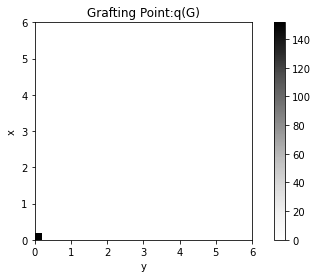

In [27]:
# Set initial conditions for the propagator
q_init = {"G":np.zeros(nx)}
q_init["G"][0,0,0] = 1.0/cb.get_dv(0)

plt.figure(figsize=(8, 4))
plt.title('Grafting Point:q(G)')
plt.xlabel('y')
plt.ylabel('x')
plt.imshow(q_init["G"][0,:,:], extent=(0, lx[1], 0, lx[0]), origin='lower', cmap=cm.Greys)  # , interpolation='nearest',
plt.colorbar()
plt.show()

# Set potential field
w_A =  np.zeros(nx)
w = {"A": w_A}

### 6. Solving the modified diffusion equations and compute single chain partition function

The foward propagators:
\begin{align}
\left[-\frac{\partial}{\partial s} + \frac{b_A^2}{6}\nabla^2 - w_A({\bf r})\right] q^{0 \rightarrow 1}_0({\bf r}, s)=0,\ \ \ \ \ s\in [0, 1] \\
\end{align}

The backword propagators:
\begin{align}
\left[-\frac{\partial}{\partial s} + \frac{b_A^2}{6}\nabla^2 - w_A({\bf r})\right] q^{1 \rightarrow 0}_0({\bf r}, s)=0,\ \ \ \ \ s\in [0, 1] \\
\end{align}

Single chain partition function:
\begin{align}
Q_0 = \frac{1}{V}\int d{\bf r}\ q^{0 \rightarrow 1}_0({\bf r}, s)q^{1 \rightarrow 0}_0({\bf r}, f_A-s) 
\end{align}

In [28]:
# Create a real space solver
solver = factory.create_realspace_solver(cb, molecules, propagator_computation_optimizer)

# Compute Propagators (q) and single partition function (Q)
solver.compute_propagators({"A":w["A"]}, q_init=q_init)

### 7. Compute end-to-end distance

* Mean-squared distance of $n$ th monomer for Continuous Chain
\begin{align}
\left<x^2\right>_n = b^2_B n
\end{align}

* Mean-squared distance of $n$ th monomer for Discrete Chain
\begin{align}
\left<x^2\right>_n = b^2_B (n-1)
\end{align}

In the numerical computation, $\left<x^2\right>_n = \frac{(b_A)^2n}{b^2N}$ for the continuous chain.

In [29]:
# Mesh for computing end-to-end distance
dx = np.array(lx)/np.array(nx)
x = []

for i in range(3):
     min_distance = np.min(np.abs(np.stack((np.linspace(0.0, lx[i], num=nx[i], endpoint=False), np.linspace(-lx[i], 0.0, num=nx[i], endpoint=False)))), axis=0)
     print(f"min_distance[{i}]:", min_distance)
     x.append(min_distance)
xv, yv, zv = np.meshgrid(x[0], x[1], x[2], indexing='ij')
distance_square = np.reshape(xv**2+yv**2+zv**2, np.prod(nx))
print("")

# Compute <x^2>
N = round(1.0/ds)
for n in range(10, round(N)+1, 10):
                                       # p, v, u, n
     q_out = solver.get_chain_propagator(0, v, u, n)
     x_square = np.sum(q_out*distance_square)/np.sum(q_out)
     
     if molecules.get_model_name() == "continuous":
          x_square *= N/n
          print("n, <x^2>N/n:", n, x_square)
     elif molecules.get_model_name() == "discrete":
          x_square *= N/(n-1)
          print("n, <x^2>N/(n-1):", n, x_square)

min_distance[0]: [0.     0.1875 0.375  0.5625 0.75   0.9375 1.125  1.3125 1.5    1.6875
 1.875  2.0625 2.25   2.4375 2.625  2.8125 3.     2.8125 2.625  2.4375
 2.25   2.0625 1.875  1.6875 1.5    1.3125 1.125  0.9375 0.75   0.5625
 0.375  0.1875]
min_distance[1]: [0.     0.1875 0.375  0.5625 0.75   0.9375 1.125  1.3125 1.5    1.6875
 1.875  2.0625 2.25   2.4375 2.625  2.8125 3.     2.8125 2.625  2.4375
 2.25   2.0625 1.875  1.6875 1.5    1.3125 1.125  0.9375 0.75   0.5625
 0.375  0.1875]
min_distance[2]: [0.     0.1875 0.375  0.5625 0.75   0.9375 1.125  1.3125 1.5    1.6875
 1.875  2.0625 2.25   2.4375 2.625  2.8125 3.     2.8125 2.625  2.4375
 2.25   2.0625 1.875  1.6875 1.5    1.3125 1.125  0.9375 0.75   0.5625
 0.375  0.1875]

n, <x^2>N/n: 10 1.6899999999999868
n, <x^2>N/n: 20 1.6899999999509252
n, <x^2>N/n: 30 1.689999993522842
n, <x^2>N/n: 40 1.6899998319011658
n, <x^2>N/n: 50 1.689998254064346
n, <x^2>N/n: 60 1.689989779861219
n, <x^2>N/n: 70 1.6899593073866215
n, <x^2>N/n: 80 1.6

In [30]:
import matplotlib.animation as animation
from IPython.display import HTML

p,v,u=(0, 0, 1)

# Create an animation of the chain propagator
fig, ax = plt.subplots(figsize=(8, 4))
im = ax.imshow(np.reshape(solver.get_chain_propagator(p, v, u, 0), nx)[0,:,:], extent=(0, lx[1], 0, lx[0]), origin='lower', cmap=cm.Greys) 
fig.colorbar(im, ax=ax)
def update(frame):
    data = np.reshape(solver.get_chain_propagator(p, v, u, frame), nx)[0,:,:]
    im.set_array(data)
    im.set_clim(vmin=np.min(data), vmax=np.max(data))
    return [im]
anim = animation.FuncAnimation(fig, update, frames=100, interval=1, repeat=False)

# Close the static figure to prevent it from displaying
plt.close(fig)

# Display only the animation
HTML(anim.to_jshtml())